In [79]:
# IMPORTS AND COMMONLY USED FUNCTIONS
# ==> always run first, change server to match the desired one

import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# "global" | "asia" | "jpn" | "kor"
server = "global"


uid_df = pd.read_json('epic7_user_world_{}.json'.format(server))
users = dict()
for x in range(len(uid_df)):
    u = dict(uid_df.iloc[x]["users"])
    users[u["nick_no"]] = u["nick_nm"]

users2 = dict()
for x in range(len(uid_df)):
    u = dict(uid_df.iloc[x]["users"])
    users2[u["nick_nm"]] = u["nick_no"]
    
heroname_df = pd.read_json('heronames.json')
heronames = dict()
for x in range(len(heroname_df)):
    heronames[heroname_df.iloc[x]["code"]] = heroname_df.iloc[x]["name"]
    
def getHeroName(code):
    return heronames[code]
def getUID(name):
    return users2[name]
def getUsername(uid):
    return users[uid]

In [80]:
# LOOK FOR SUSPICIOUSLY SHORT GAMES
# max_turns: the amount of turns or less the game is allowed to last

def findShortGames(uid, max_turns=1):
    url = "https://epic7.gg.onstove.com/gameApi/getBattleList?nick_no={}&world_code=world_{}&lang=en&season_code=".format(uid, server)
    payload = {}
    response = requests.post(url, json=payload)

    filename = '{userId}.json'.format(userId=uid)
    if response.status_code == 200:
        json_data = response.json()
        with open(filename, 'w') as file:
            json.dump(json_data, file, indent=4)

        battles = pd.read_json(filename)
        battles = dict(battles.loc["battle_list"])['result_body']
        ffs = dict()
        for x in range(len(battles)):
            if battles[x]["season_code"] == "pvp_rta_ss11" and battles[x]["turn"] <= max_turns:
                if battles[x]["enemy_nick_no"] in ffs:
                    ffs[battles[x]["enemy_nick_no"]] = ffs[battles[x]["enemy_nick_no"]] + 1
                else: 
                    ffs[battles[x]["enemy_nick_no"]] = 1
        matches = dict()
        wins = dict()
        for x in range(len(battles)):
            for y in ffs.keys():
                if battles[x]["season_code"] == "pvp_rta_ss11" and battles[x]["enemy_nick_no"] == y:
                    if battles[x]["enemy_nick_no"] in matches:
                        matches[battles[x]["enemy_nick_no"]] = matches[battles[x]["enemy_nick_no"]] + 1
                    else: 
                        wins[battles[x]["enemy_nick_no"]] = 0
                        matches[battles[x]["enemy_nick_no"]] = 1

                    if battles[x]["iswin"] == 1:
                        wins[battles[x]["enemy_nick_no"]] = wins[battles[x]["enemy_nick_no"]] + 1
        print(users[str(uid)]+" - games ended before turn 2:")
        for y in ffs.keys():
            print("{}: {}/{} ({}), winrate against: {}".format(y, ffs[y], matches[y], str(100*ffs[y]/matches[y])+"%", str(100*wins[y]/matches[y])+"%"))
    else:
        print(f'Error: {response.status_code}')
        print(response.text)

In [81]:
# LOOK FOR SUSPICIOUS PICKS
# sus_log_p: the log probability limit for showing games
# -30 seems to be a decently good value


def findSuspiciousPicks(uid, sus_log_p=-30):
    url = "https://epic7.gg.onstove.com/gameApi/getBattleList?nick_no={}&world_code=world_{}&lang=en&season_code=".format(uid, server)
    payload = {}
    response = requests.post(url, json=payload)


    filename = '{userId}.json'.format(userId=uid)
    if response.status_code == 200:
        json_data = response.json()
        with open(filename, 'w') as file:
            json.dump(json_data, file, indent=4)

        battles = pd.read_json(filename)
        battles = dict(battles.loc["battle_list"])['result_body']

        enemies = dict()
        heroes = dict()
        total_picks = 0
        total_battles = 0
        for x in range(len(battles)):
            if battles[x]["season_code"] == "pvp_rta_ss11":
                total_battles = total_battles + 1
                if battles[x]["enemy_nick_no"] in enemies:
                    enemies[battles[x]["enemy_nick_no"]] = enemies[battles[x]["enemy_nick_no"]] + 1
                else: 
                    enemies[battles[x]["enemy_nick_no"]] = 1    
                h = battles[x]["my_deck"]["hero_list"]
                for x2 in range(len(h)):
                    total_picks = total_picks + len(h)
                    if h[x2]["hero_code"] in heroes:
                        heroes[h[x2]["hero_code"]] = heroes[h[x2]["hero_code"]] + 1
                    else:
                        heroes[h[x2]["hero_code"]] = 1

        for hero in heroes.keys():
            heroes[hero] = np.log(heroes[hero]) - np.log(total_picks)

        battle_log_p = [1]*total_battles
        x5 = 0
        picks = [""]*total_battles
        for x in range(len(battles)):
            if battles[x]["season_code"] == "pvp_rta_ss11":   
                h = battles[x]["my_deck"]["hero_list"]
                for x2 in range(len(h)):
                    if x2 == 0:
                        picks[x5] = picks[x5] + getHeroName(h[x2]["hero_code"])
                    else:
                        picks[x5] = picks[x5] + ", " + getHeroName(h[x2]["hero_code"])
                    if h[x2]["hero_code"] in heroes:
                        battle_log_p[x5] = battle_log_p[x5] + heroes[h[x2]["hero_code"]]
                x5 = x5 + 1

        plt.hist([i for i in battle_log_p if i != 1], 30)
        sus_games = []
        for x3 in range(len(battle_log_p)):
            if battle_log_p[x3] < sus_log_p:
                sus_games.append(x3)

        print(users[str(uid)]+" - games with suspicious picks:")
        for x3 in range(len(sus_games)):
            print("Game number: {}, log P: {}, picks: {}".format(sus_games[x3], battle_log_p[sus_games[x3]], picks[sus_games[x3]]))
    else:
        print(f'Error: {response.status_code}')
        print(response.text)

In [89]:
findShortGames(63471324)

Caerliss - games ended before turn 2:
biru速: 3/4 (75.0%), winrate against: 100.0%
Lunale速: 7/7 (100.0%), winrate against: 100.0%


Caerliss - games with suspicious picks:
Game number: 32, log P: -30.184710000521882, picks: Seaside Bellona, Lua, Last Rider Krau, Archdemon's Shadow, Destina


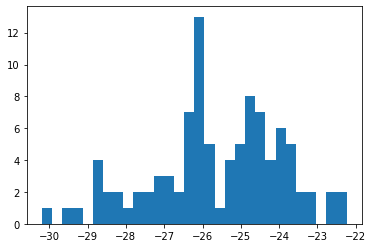

In [90]:
findSuspiciousPicks(63471324)

In [82]:
# GET ALL GLOBAL PLAYER DATA

def getAllGlobalData():
    n = len(uid_df)
    uids2 = [0]*n
    n1 = 0
    for x in range(n):
        if int(dict(uid_df.iloc[x])["users"]["rank"]) == 70:
            n1 = n1 + 1
            uids2[x] = int(dict(uid_df.iloc[x])["users"]["nick_no"])

    uids = [0]*n1
    n2 = 0
    for x in range(n):
        if uids2[x] != 0:
            uids[n2] = uids2[x]
            n2 = n2 + 1

    print(len(uids))

    for x in range(n):
        uid = uids[x]
        url = "https://epic7.gg.onstove.com/gameApi/getBattleList?nick_no={userId}&world_code=world_global&lang=en&season_code="
        payload = {}
        response = requests.post(url.format(userId=uid), json=payload)

        if response.status_code == 200:
            # Parse the JSON response
            json_data = response.json()
            filename = '{userId}.json'.format(userId=uid)
            with open(filename, 'w') as file:
                json.dump(json_data, file, indent=4)
            print(x+"/"+n)
        else:
            print(f'Error: {response.status_code}')
            print(response.text)